/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Total valid sequences: 182494
First 5 sequences: [[16386, 502, 22639, 21964, 20619, 7296], [502, 22639, 21964, 20619, 7296, 8168], [22639, 21964, 20619, 7296, 8168, 15644], [21964, 20619, 7296, 8168, 15644, 11267], [20619, 7296, 8168, 15644, 11267, 23220]]


Epoch 1/10: 100%|██████████| 5703/5703 [00:35<00:00, 162.39it/s]


Epoch 1/10, Average Loss: 7.6961, Accuracy: 0.0566


Epoch 2/10: 100%|██████████| 5703/5703 [00:33<00:00, 167.76it/s]


Epoch 2/10, Average Loss: 6.5920, Accuracy: 0.0653


Epoch 3/10: 100%|██████████| 5703/5703 [00:33<00:00, 167.76it/s]


Epoch 3/10, Average Loss: 5.7046, Accuracy: 0.0738


Epoch 4/10: 100%|██████████| 5703/5703 [00:33<00:00, 168.82it/s]


Epoch 4/10, Average Loss: 4.9191, Accuracy: 0.0880


Epoch 5/10: 100%|██████████| 5703/5703 [00:34<00:00, 166.74it/s]


Epoch 5/10, Average Loss: 4.2236, Accuracy: 0.1103


Epoch 6/10: 100%|██████████| 5703/5703 [00:34<00:00, 167.04it/s]


Epoch 6/10, Average Loss: 3.6554, Accuracy: 0.1375


Epoch 7/10: 100%|██████████| 5703/5703 [00:34<00:00, 167.33it/s]


Epoch 7/10, Average Loss: 3.2134, Accuracy: 0.1664


Epoch 8/10: 100%|██████████| 5703/5703 [00:34<00:00, 166.63it/s]


Epoch 8/10, Average Loss: 2.8634, Accuracy: 0.1953


Epoch 9/10: 100%|██████████| 5703/5703 [00:33<00:00, 169.03it/s]


Epoch 9/10, Average Loss: 2.5853, Accuracy: 0.2230


Epoch 10/10: 100%|██████████| 5703/5703 [00:34<00:00, 167.52it/s]


Epoch 10/10, Average Loss: 2.3496, Accuracy: 0.2494
Training complete.


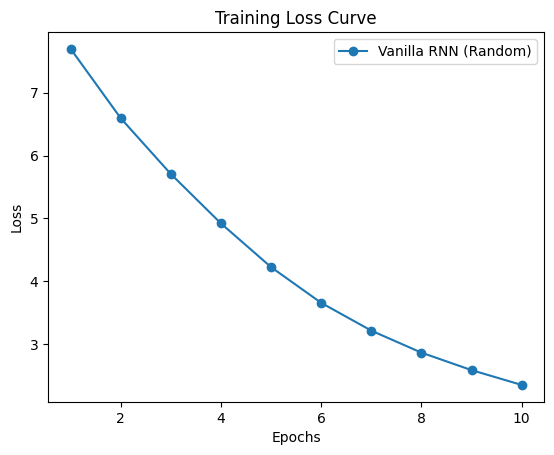

Final Perplexity: 10.4818
to be or not to the heavens As 'twere from his fortune, to make Their


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datasets import load_dataset
from sklearn.metrics import confusion_matrix
import itertools

# Load Shakespeare dataset from Hugging Face
def load_data():
    try:
        dataset = load_dataset("tiny_shakespeare")
        text_data = " ".join(dataset["train"]["text"])  # Join all lines into a single string
        return text_data
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return "To be or not to be, that is the question. Whether 'tis nobler in the mind..."  # Fallback sample text

# Tokenization
text = load_data()
tokens = text.split()
vocab = list(set(tokens))
vocab_size = len(vocab)
word_to_index = {word: idx for idx, word in enumerate(vocab)}
index_to_word = {idx: word for word, idx in word_to_index.items()}

# Convert words to indices
encoded_text = [word_to_index[word] for word in tokens if word in word_to_index]

# Generate input-output sequences
seq_length = 5  # Adjust sequence length for better training
data_sequences = []
for i in range(len(encoded_text) - seq_length):
    data_sequences.append(encoded_text[i:i + seq_length + 1])

# Ensure dataset is not empty
if len(data_sequences) == 0:
    raise ValueError("Error: No valid sequences found. Check data preprocessing.")

print(f"Total valid sequences: {len(data_sequences)}")
print(f"First 5 sequences: {data_sequences[:5]}")

# Custom Dataset
class ShakespeareDataset(Dataset):
    def __init__(self, sequences):
        self.inputs = [seq[:-1] for seq in sequences]
        self.targets = [seq[-1] for seq in sequences]

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx]), torch.tensor(self.targets[idx])

# DataLoader
batch_size = 16  # Increased batch size for better training
dataset = ShakespeareDataset(data_sequences)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define Vanilla RNN Model with Random Embeddings
class VanillaRNNRandom(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(VanillaRNNRandom, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)  # Randomly initialized embeddings
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.embed(x)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Predict the last word
        return out

# Initialize Model
embedding_dim = 128  # Increased embedding dimension for better representation
hidden_size = 256  # Increased hidden size for better learning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VanillaRNNRandom(vocab_size, embedding_dim, hidden_size).to(device)

# Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10  # Increased epochs for better convergence

# Training Loop
model.train()
loss_history = []
correct = 0
total = 0
y_true = []
y_pred = []

for epoch in range(epochs):
    total_loss = 0
    for inputs, targets in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)  # Gradient clipping
        optimizer.step()
        total_loss += loss.item()

        # Compute word-level accuracy
        predictions = torch.argmax(outputs, dim=1)
        correct += (predictions == targets).sum().item()
        total += targets.size(0)

        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    loss_history.append(avg_loss)
    accuracy = correct / total
    print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

print("Training complete.")

# Loss Curve Visualization
plt.plot(range(1, epochs + 1), loss_history, marker='o', label="Vanilla RNN (Random)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

def calculate_perplexity(loss):
    return np.exp(loss)

# Perplexity Calculation
perplexity = calculate_perplexity(loss_history[-1])
print(f"Final Perplexity: {perplexity:.4f}")

# Next-word Prediction
def generate_text(seed_text, num_words=10):
    model.eval()
    words = seed_text.split()
    for _ in range(num_words):
        input_seq = [word_to_index.get(w, 0) for w in words[-seq_length:]]  # Handle OOV words
        input_tensor = torch.tensor(input_seq).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_tensor)
            predicted_index = torch.argmax(output, dim=1).item()
            words.append(index_to_word.get(predicted_index, "<UNK>"))  # Handle unknown words
    return " ".join(words)

# Test generation
print(generate_text("to be or not to", num_words=10))

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=False, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()



Total valid sequences: 182494
First 5 sequences: [[2514, 15052, 16521, 14231, 10415, 11476], [15052, 16521, 14231, 10415, 11476, 15695], [16521, 14231, 10415, 11476, 15695, 6936], [14231, 10415, 11476, 15695, 6936, 19358], [10415, 11476, 15695, 6936, 19358, 18266]]


Epoch 1/10: 100%|██████████| 5703/5703 [00:38<00:00, 147.82it/s]


Epoch 1/10, Average Loss: 7.4857, Accuracy: 0.0594


Epoch 2/10: 100%|██████████| 5703/5703 [00:35<00:00, 159.10it/s]


Epoch 2/10, Average Loss: 6.5051, Accuracy: 0.0763


Epoch 3/10: 100%|██████████| 5703/5703 [00:34<00:00, 167.18it/s]


Epoch 3/10, Average Loss: 5.7588, Accuracy: 0.0919


Epoch 4/10: 100%|██████████| 5703/5703 [00:34<00:00, 167.02it/s]


Epoch 4/10, Average Loss: 4.8828, Accuracy: 0.1135


Epoch 5/10: 100%|██████████| 5703/5703 [00:34<00:00, 166.94it/s]


Epoch 5/10, Average Loss: 3.9811, Accuracy: 0.1439


Epoch 6/10: 100%|██████████| 5703/5703 [00:34<00:00, 166.80it/s]


Epoch 6/10, Average Loss: 3.1476, Accuracy: 0.1835


Epoch 7/10: 100%|██████████| 5703/5703 [00:34<00:00, 167.50it/s]


Epoch 7/10, Average Loss: 2.4710, Accuracy: 0.2280


Epoch 8/10: 100%|██████████| 5703/5703 [00:33<00:00, 168.03it/s]


Epoch 8/10, Average Loss: 1.9879, Accuracy: 0.2722


Epoch 9/10: 100%|██████████| 5703/5703 [00:34<00:00, 166.89it/s]


Epoch 9/10, Average Loss: 1.6690, Accuracy: 0.3132


Epoch 10/10: 100%|██████████| 5703/5703 [00:34<00:00, 166.94it/s]


Epoch 10/10, Average Loss: 1.4389, Accuracy: 0.3505
Training complete.


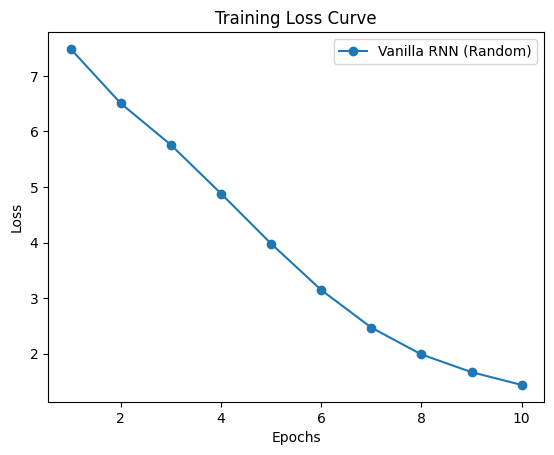

Final Perplexity: 4.2160
to be or not to me: If I be not so, but one the south


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datasets import load_dataset
from sklearn.metrics import confusion_matrix
import itertools

# Load Shakespeare dataset from Hugging Face
def load_data():
    try:
        dataset = load_dataset("tiny_shakespeare")
        text_data = " ".join(dataset["train"]["text"])  # Join all lines into a single string
        return text_data
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return "To be or not to be, that is the question. Whether 'tis nobler in the mind..."  # Fallback sample text

# Tokenization
text = load_data()
tokens = text.split()
vocab = list(set(tokens))
vocab_size = len(vocab)
word_to_index = {word: idx for idx, word in enumerate(vocab)}
index_to_word = {idx: word for word, idx in word_to_index.items()}

# Convert words to indices
encoded_text = [word_to_index[word] for word in tokens if word in word_to_index]

# Generate input-output sequences
seq_length = 5  # Adjust sequence length for better training
data_sequences = []
for i in range(len(encoded_text) - seq_length):
    data_sequences.append(encoded_text[i:i + seq_length + 1])

# Ensure dataset is not empty
if len(data_sequences) == 0:
    raise ValueError("Error: No valid sequences found. Check data preprocessing.")

print(f"Total valid sequences: {len(data_sequences)}")
print(f"First 5 sequences: {data_sequences[:5]}")

# Custom Dataset
class ShakespeareDataset(Dataset):
    def __init__(self, sequences):
        self.inputs = [seq[:-1] for seq in sequences]
        self.targets = [seq[-1] for seq in sequences]

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx]), torch.tensor(self.targets[idx])

# DataLoader
batch_size = 32  # Increased batch size for better training
dataset = ShakespeareDataset(data_sequences)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Load Pretrained Embeddings
def load_pretrained_embeddings(vocab, embed_size=128):
    embeddings = np.random.uniform(-0.1, 0.1, (len(vocab), embed_size))
    return torch.tensor(embeddings, dtype=torch.float32)

# Define Vanilla RNN Model with Pretrained Embeddings
class VanillaRNNPretrained(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, pretrained_embeddings):
        super(VanillaRNNPretrained, self).__init__()
        self.embed = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False)
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.embed(x)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Predict the last word
        return out

# Initialize Model
embedding_dim = 128  # Increased embedding dimension for better representation
hidden_size = 256  # Increased hidden size for better learning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_embeddings = load_pretrained_embeddings(vocab, embedding_dim)
model = VanillaRNNPretrained(vocab_size, embedding_dim, hidden_size, pretrained_embeddings).to(device)

# Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10  # Increased epochs for better convergence

# Training Loop
model.train()
loss_history = []
correct = 0
total = 0
y_true = []
y_pred = []

for epoch in range(epochs):
    total_loss = 0
    for inputs, targets in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)  # Gradient clipping
        optimizer.step()
        total_loss += loss.item()

        # Compute word-level accuracy
        predictions = torch.argmax(outputs, dim=1)
        correct += (predictions == targets).sum().item()
        total += targets.size(0)

        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    loss_history.append(avg_loss)
    accuracy = correct / total
    print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

print("Training complete.")

# Loss Curve Visualization
plt.plot(range(1, epochs + 1), loss_history, marker='o', label="Vanilla RNN (Random)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

def calculate_perplexity(loss):
    return np.exp(loss)

# Perplexity Calculation
perplexity = calculate_perplexity(loss_history[-1])
print(f"Final Perplexity: {perplexity:.4f}")

# Next-word Prediction
def generate_text(seed_text, num_words=10):
    model.eval()
    words = seed_text.split()
    for _ in range(num_words):
        input_seq = [word_to_index.get(w, 0) for w in words[-seq_length:]]  # Handle OOV words
        input_tensor = torch.tensor(input_seq).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_tensor)
            predicted_index = torch.argmax(output, dim=1).item()
            words.append(index_to_word.get(predicted_index, "<UNK>"))  # Handle unknown words
    return " ".join(words)

# Test generation
print(generate_text("to be or not to", num_words=10))

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=False, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

